# Distribution fitting tutorial

In [1]:
import numpy as np
import scipy.signal as signal
from scipy.optimize import least_squares
from scipy.special import wofz

from utils import *

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

We first need to generate the fake 'detrended'-data with no noise.

In [2]:
# get the testing spectra here
gratings = 1000
x_values, synthetic_spectral_data = generate_fake_spectral_data(length=100, num_peaks=2, noise_level=0.2)
synthetic_spectral_data = np.abs(synthetic_spectral_data)
synthetic_spectral_data = np.abs(synthetic_spectral_data - arPLS(synthetic_spectral_data))
interpolated = Interpolate(x_values, synthetic_spectral_data, gratings=gratings)
interpolated.denoise_signal()

Maximum number of iterations exceeded


In [3]:
peaks = find_peaks(interpolated, window_size=10, threshold=0.3)

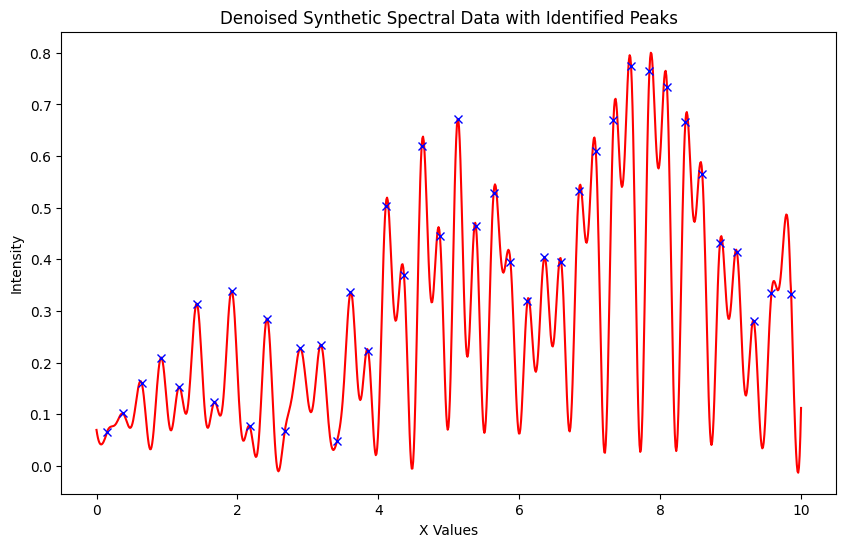

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.show()

# Gaussian fittings

In [14]:
class GaussianFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, parallel=True):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.sigmas = np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes,self.sigmas]).T  
        if parallel:
            self.start_params = self.params.tolist()
        else:
            self.start_params = self.params.flatten().tolist()
        # result to output
        self.result = None
                
        if parallel:
            self.approximator_parallel()
        else:
            self.approximator()
        
    """
        for serial computation
    """
    
    def approximator(self):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            max_nfev=10,
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.gaussian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def gaussian(self, x, center, amplitude, sigma):
        return amplitude * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))

    def gaussian_sum(self, x, params):
        params = params.flatten().tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.gaussian(x, center, amp, sigma) for center, amp, sigma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.gaussian_sum(x_vals, params)
    """
        for parallel computation
    """
    def approximator_parallel(self, num_jobs=-1):
        results = []

        def process_peak(index):
            peak_params, peak_results, peak_error = self.fit_peak(index)
            results.append((index, peak_params, peak_results, peak_error))

        # Dynamic peak assignment and parallel processing
        num_peaks = len(self.centers)
        peak_indices = list(range(num_peaks))

        while len(peak_indices) > 0:
            # Distribute available peaks among processes
            current_indices = peak_indices[:num_jobs] if num_jobs != -1 else peak_indices
            peak_indices = peak_indices[num_jobs:]

            # Process peaks in parallel
            Parallel(n_jobs=num_jobs, backend="threading")(
                delayed(process_peak)(i) for i in current_indices
            )

        # Sort the results by peak index
        results.sort(key=lambda x: x[0])

        # Combine results
        self.params = np.concatenate([result[1] for result in results])
        self.results = np.sum([result[2] for result in results], axis=0)
        self.results /= (len(self.params) / 3.0)

        print(self.params)
        print("the error for this run is: ", np.mean(np.abs(self.y_vals - self.results)))
    
    def fit_peak(self, peak_index):
        peak_params = least_squares(self.residual_peak,
                                     self.start_params[peak_index],
                                     args=(peak_index,),
                                     bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                                     ftol=1e-6, xtol=1e-6, loss='soft_l1',
                                     f_scale=0.1).x

        peak_results = self.gaussian_sum(self.x_vals, peak_params)
        peak_error = np.mean(np.abs(self.y_vals - peak_results))
        

        return peak_params, peak_results, peak_error

    def residual_peak(self, params, peak_index):
        params_all = self.params.copy()
        params_all[peak_index * 3: (peak_index + 1) * 3] = params
        
        return self.y_vals - self.gaussian_sum(self.x_vals, params_all)

In [15]:
gauss = GaussianFitter(interpolated, peaks, parallel=False)

[ 0.40903406 -1.0891754   0.40788278  0.66141206  0.48511011  0.09124659
  0.85076375  1.98504054  0.63917603  0.92000105  2.26171117 -0.13073425
  1.40930111  0.57385404  0.07911441  1.04198045 -4.08332799  0.26419211
  1.16595775  2.19799157  0.13387538  2.02411102  2.38881092  0.0963593
  2.03195463 -2.16922335  0.08592808  2.41922654  0.30809965  0.06483832
  2.42038476  0.73297077  0.26250823  2.95796131  1.4148815   0.23696416
  3.31575166  3.45641644  0.11564273  3.30988543 -2.2454501   0.09434702
  3.60054045  1.66979126  0.10780173  4.00722544  4.00605176  0.19119868
  4.3735773   1.95763531 -0.099561    3.98463359 -1.69979461  0.09329211
  4.61955016  2.70985295  0.10481647  4.86695606  2.42928259  0.1093273
  5.1199588   2.12567455 -0.09252858  5.48500086  3.49832344 -0.1523324
  5.5037446  -2.42364278  0.09633896  5.85511478  0.42968757 -0.06125857
  6.82507688 -4.57296667  2.48871296  6.37820812  4.81224012  0.89644218
  6.60132705  0.2860783   0.05034316  6.86163518  0.83

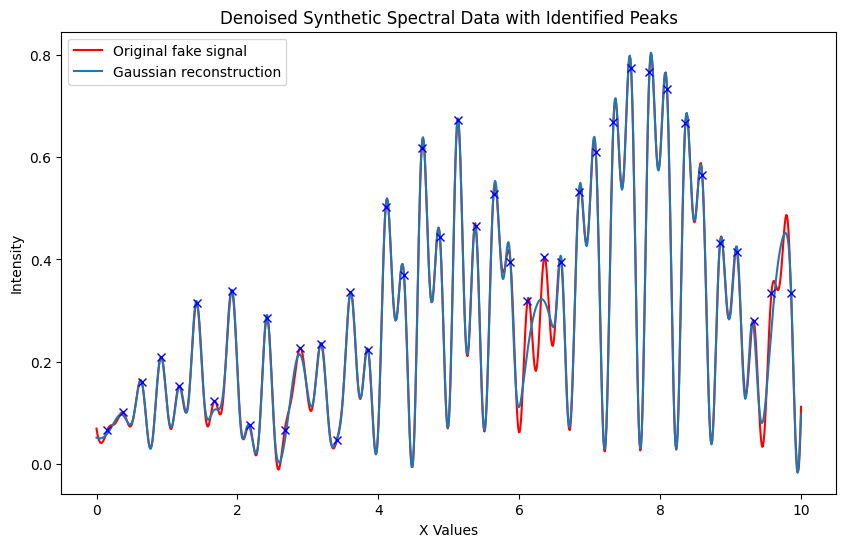

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(gauss.x_vals, gauss.results, label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Lorentzians

In [20]:
class LorentzianFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gammas = [1]*len(self.centers)
        self.params = np.array([self.centers, self.amplitudes,self.gammas]).T
        self.start_params = self.params.flatten().tolist()     

        self.approximator(max_iter)
        
    def approximator(self,max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.lorentzian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def lorentzian(self, x, center, amplitude, gamma):
        return amplitude * (gamma / np.pi) / ((x - center) ** 2 + gamma ** 2)

    def lorentzian_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.lorentzian(x, centre, amp, gamma) for centre, amp, gamma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.lorentzian_sum(x_vals, params)

In [28]:
lorentz = LorentzianFitter(interpolated, peaks, max_iter=1000)

[ 8.29009740e-02 -6.94621035e-03  6.13037523e-02  6.47836979e-01
  7.08340215e-02  9.75020008e-02  9.29827017e-01  3.26790431e+00
  2.20396097e-01  9.57596824e-01 -8.89624499e+00  2.97985608e-01
  1.38237675e+00 -1.76515708e+00  2.09493140e-01  1.40155825e+00
  1.01554361e+00  1.54391800e-01  1.91964186e+00  6.41744610e-02
  6.97835614e-02  1.03643469e+00  7.03144963e+00  4.00904809e-01
  2.44032593e+00 -1.94851667e+00  1.39579805e-01  3.04076722e+00
  3.63927546e+00  2.78851608e-01  2.43760912e+00  1.93250665e+00
  1.31218677e-01  4.02769523e+00  4.38610679e+00  1.87945459e-01
  3.71689446e+00  3.63340220e+00  1.64528299e-01  3.10123284e+00
 -6.26308899e+00  2.55559609e-01  3.14363159e+00  2.87886770e+00
  2.14162009e-01  4.01337051e+00 -3.45818184e+00  1.66095380e-01
  3.72040555e+00 -3.12370356e+00  1.50246523e-01  4.96143748e+00
 -1.00000000e+01  6.30840116e-01  5.12015971e+00  1.26350507e+00
  1.49353678e-01  4.36072685e+00  3.99587781e-01  1.19308596e-01
  4.62827838e+00  1.11605

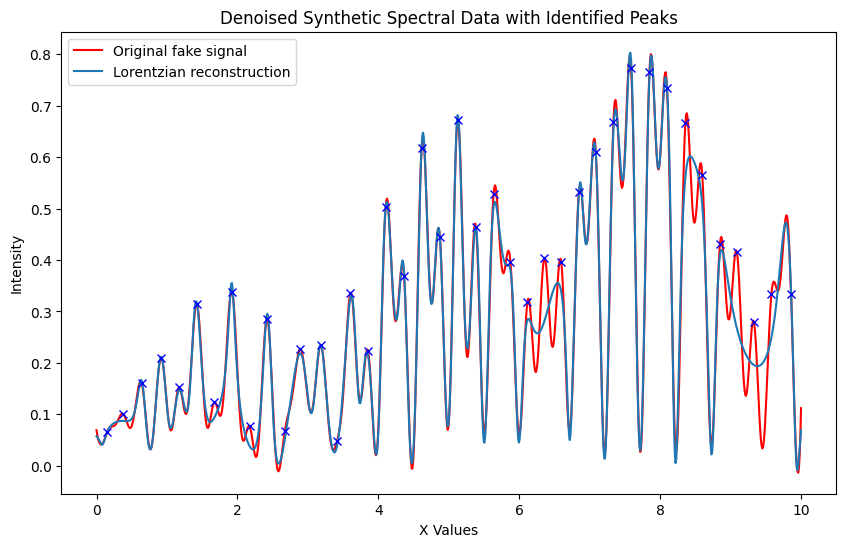

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(lorentz.x_vals, lorentz.lorentzian_sum(lorentz.x_vals, lorentz.params), label='Lorentzian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Voigt

In [30]:
class VoigtFitter():
    def __init__(self, InterpolatedData, peaks, threshold=0.1, max_iter=100, parallel=False):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        self.threshold = threshold
        self.parallel = parallel
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gauss_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.lorentz_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes, self.gauss_widths, self.lorentz_widths]).T
        if parallel:
            self.start_params = self.params.tolist()
        else:
            self.start_params = self.params.flatten().tolist()
        num_dists = len(self.centers)
        
        if parallel:
            self.approximator_parallel(num_jobs=num_dists)
        else:
            self.approximator(max_iter)
        
    def approximator(self,max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.voigt_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def voigt(self, x, center, amplitude, gauss_width, lorentz_width):
        sigma = gauss_width / np.sqrt(2 * np.log(2))
        gamma = lorentz_width
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2) + 1e-20)
        return amplitude * np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi) + 1e-20)

    def voigt_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 4] for i in range(0, len(params), 4)]
        return np.sum([self.voigt(x, centre, amp, gw, lw) for centre, amp, gw, lw in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.voigt_sum(x_vals, params)
    """
        for parallel computation
    """
    def approximator_parallel(self, num_jobs=-1):
        initial_params = np.random.rand(len(self.centers) * 4)

        # Create copies of parameters for each parallel process
        peak_params_list = [initial_params[i * 4: (i + 1) * 4] for i in range(len(self.centers))]

        # Run parallelized fitting for all peaks
        results = Parallel(n_jobs=num_jobs)(
            delayed(self.fit_peak)(peak_params_list[i], i) for i in range(len(self.centers))
        )

        # Combine results and update self.params after all processes have finished
        new_params = []
        fitted_results = []
        for result in results:
            new_params.extend(result[0])
            fitted_results.append(result[1])

        self.params = np.array(new_params)
        self.results = np.sum(fitted_results, axis=0) / len(self.centers)

        print(self.params)
        print("the error for this run is: ", np.mean(np.abs(self.y_vals - self.results)))

    def fit_peak(self, peak_params, peak_index):
        result = least_squares(self.residual_peak,
                               peak_params,
                               args=(peak_index,),
                               bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                               ftol=1e-12, xtol=1e-12, loss='soft_l1',
                               f_scale=0.1)

        peak_fitted_params = result.x
        peak_results = self.voigt_sum(self.x_vals, peak_fitted_params)

        return peak_fitted_params, peak_results

    def residual_peak(self, params, peak_index):
        # Calculate residuals without modifying shared data
        temp_params = np.array(self.params)
        temp_params[peak_index * 4: (peak_index + 1) * 4] = params
        return self.y_vals - self.voigt_sum(self.x_vals, temp_params)


In [31]:
voigt = VoigtFitter(interpolated, peaks,parallel=False)

c:\Python312\Lib\site-packages\scipy\optimize\_lsq\least_squares.py:221: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 2.94919000e-03 -3.05038524e-01  1.08932607e+00  1.06207883e+00
  3.22530452e-01 -1.09405947e-01  1.05165251e+00  1.03828641e+00
  6.00101560e-01  1.61787657e-01  8.21724664e-01  8.99313943e-01
  5.19209454e-01  5.33443700e-01  4.55099112e-01  5.33473489e-01
  1.09891293e+00 -9.33840731e-02  9.75109492e-01  1.00772377e+00
  1.67112076e+00  5.19136515e-01  5.62720272e-01  1.55522919e-01
  1.68363167e+00 -3.93962897e-01  9.14760871e-01  9.67646156e-01
  1.83045746e+00 -1.65985396e-01  1.10923274e+00  1.05611263e+00
  2.04181106e+00 -4.77610503e-01  7.43442892e-01  8.81026575e-01
  2.45979192e+00  9.11862603e-03  1.02563266e+00  1.02460896e+00
  2.66862988e+00  7.71419599e-03  1.02952007e+00  1.03218822e+00
  3.00999207e+00  7.66410401e-01  2.87856752e-01 -7.51384006e-02
  3.21131792e+00  2.80551760e-01  8.69305114e-01  9.10548607e-01
  3.57674933e+00 -9.55065978e-02  1.06889508e+00  1.06437479e+00
  3.60173337e+00  6.12197203e-02  1.02248375e+00  1.02954100e+00
  3.01646016e+00 -4.33658

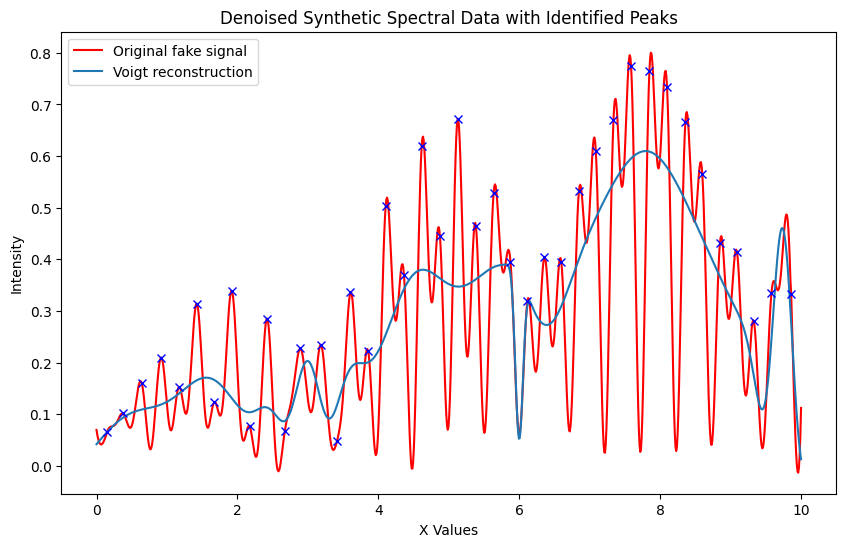

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(voigt.x_vals, voigt.results, label='Voigt reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Compare the results

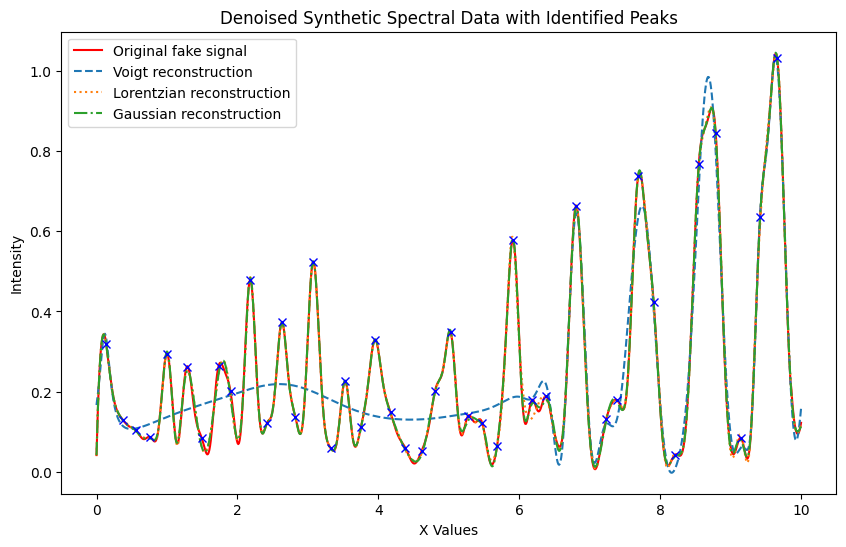

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(voigt.x_vals, voigt.results, '--', label='Voigt reconstruction')
plt.plot(lorentz.x_vals, lorentz.results, ':',label='Lorentzian reconstruction')
plt.plot(gauss.x_vals, gauss.results, '-.',label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [34]:
class GaussianFitter():
    def __init__(self, InterpolatedData, peaks,
                 max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.sigmas = np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes,self.sigmas]).T  
        self.start_params = self.params.flatten().tolist()
        # result to output
        self.result = None
                
        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.gaussian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def gaussian(self, x, center, amplitude, sigma):
        return amplitude * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))

    def gaussian_sum(self, x, params):
        params = params.flatten().tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.gaussian(x, center, amp, sigma) for center, amp, sigma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.gaussian_sum(x_vals, params)

class LorentzianFitter():
    def __init__(self, InterpolatedData, peaks,
                 max_iter=100):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gammas = [1]*len(self.centers)
        self.params = np.array([self.centers, self.amplitudes,self.gammas]).T
        self.start_params = self.params.flatten().tolist()     

        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals),
                                    np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.lorentzian_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def lorentzian(self, x, center, amplitude, gamma):
        return amplitude * (gamma / np.pi) / ((x - center) ** 2 + gamma ** 2)

    def lorentzian_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 3] for i in range(0, len(params), 3)]
        return np.sum([self.lorentzian(x, centre, amp, gamma) for centre, amp, gamma in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.lorentzian_sum(x_vals, params)
    
class VoigtFitter():
    def __init__(self, InterpolatedData, peaks, max_iter=50):
        self.x_vals = InterpolatedData.x_val
        self.y_vals = InterpolatedData.y_val
        
        # initial parameters
        self.centers = self.x_vals[peaks]
        self.amplitudes = self.y_vals[peaks]
        self.gauss_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.lorentz_widths = np.ones_like(self.amplitudes) #np.random.rand(*self.amplitudes.shape)
        self.params = np.array([self.centers, self.amplitudes, self.gauss_widths, self.lorentz_widths]).T
        self.start_params = self.params.flatten().tolist()
        num_dists = len(self.centers)
        
        self.approximator(max_iter)
        
    def approximator(self, max_iter):
        self.params = least_squares(self.residual,
                            self.start_params, args=(self.x_vals, self.y_vals),
                            bounds=(-np.max(self.x_vals), np.max(self.x_vals)),
                            ftol=1e-9, xtol=1e-9, loss='soft_l1',
                            f_scale=0.1, max_nfev=max_iter).x
        print(self.params)
        print("the error for this run is: ", np.mean(self.residual(self.params, self.x_vals, self.y_vals)))

        self.results = np.array([self.voigt_sum(x, self.params) for x in self.x_vals])
        error = np.mean(np.abs(self.y_vals - self.results))
        
        return error
    
    def voigt(self, x, center, amplitude, gauss_width, lorentz_width):
        sigma = gauss_width / np.sqrt(2 * np.log(2))
        gamma = lorentz_width
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2) + 1e-20)
        return amplitude * np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi) + 1e-20)

    def voigt_sum(self, x, params):
        params = params.tolist()
        params = [params[i:i + 4] for i in range(0, len(params), 4)]
        return np.sum([self.voigt(x, centre, amp, gw, lw) for centre, amp, gw, lw in params], axis=0)

    def residual(self, params, x_vals, y_vals):
        return y_vals - self.voigt_sum(x_vals, params)

In [39]:
# less chaotic spectra
max_iter = 300
gratings = 1000
x_values, synthetic_spectral_data = generate_fake_spectral_data(length=20, num_peaks=3) #, noise_level=0.2)
synthetic_spectral_data = np.abs(synthetic_spectral_data)
synthetic_spectral_data = np.abs(synthetic_spectral_data - arPLS(synthetic_spectral_data))
interpolated = Interpolate(x_values, synthetic_spectral_data, gratings=gratings)
interpolated.denoise_signal()
peaks = find_peaks(interpolated, window_size=5, threshold=0.5)
gauss = GaussianFitter(interpolated, peaks, max_iter=max_iter)
lorentz = LorentzianFitter(interpolated, peaks, max_iter=max_iter)
voigt = VoigtFitter(interpolated, peaks, max_iter=max_iter)

Maximum number of iterations exceeded
[-0.86332403  3.05079644  0.41748557  1.00447581  0.5834004   0.3739709
  2.11162161  0.44900936  0.32607269  3.21921739  0.31335753  0.67254532
  4.19919403  0.57061923  0.31827841  5.24883806  0.67056909  0.40435593
  6.72293856  1.014264    0.37323164  7.91845338  0.96158905  0.29018226
  9.30014738  0.9069231   0.45985534]
the error for this run is:  -0.0006732218916842428
[7.93880503e-03 6.36841762e-02 7.89806517e-02 9.90550066e-01
 6.51680410e-01 3.90431213e-01 2.16861450e+00 5.25198085e-01
 3.94072520e-01 3.09294411e+00 1.73491004e-01 4.92746203e-01
 4.16856954e+00 8.42636784e-01 4.59037328e-01 5.24325441e+00
 5.63347635e-01 3.32143964e-01 6.72499952e+00 1.05709720e+00
 3.56019226e-01 7.91674301e+00 7.02846790e-01 2.68640579e-01
 9.33846931e+00 1.32298562e+00 4.78416867e-01]
the error for this run is:  -0.0028214517162544537


c:\Python312\Lib\site-packages\scipy\optimize\_lsq\least_squares.py:221: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\kyung\AppData\Local\Temp\ipykernel_11976\572081623.py:119: RuntimeWarning: overflow encountered in divide
  return amplitude * np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi) + 1e-20)


[-4.39162483e-01  7.17137812e-01  3.57744651e-01 -5.36070277e-02
  1.12225209e+00  8.91581816e-01  3.76473721e-01  1.99268523e-01
  2.08471008e+00  3.31351183e-02  7.66676249e-01 -1.41087588e+00
  2.82172409e+00  1.19309735e-01  7.72686571e-01 -9.13406572e-01
  4.18519232e+00  1.36763807e+00  1.74070401e-01  5.19336679e-01
  5.25552142e+00  3.96623564e-01  4.06092759e-01 -9.93316931e-02
  6.81459080e+00  6.07461102e-01  3.95710103e-01 -2.83951365e-02
  7.90461144e+00  1.54552110e+00  3.84674118e-01  6.32304336e-02
  9.32472473e+00  3.68478260e-04  2.40438275e+00 -8.52550505e+00]
the error for this run is:  -0.00016877346055981394


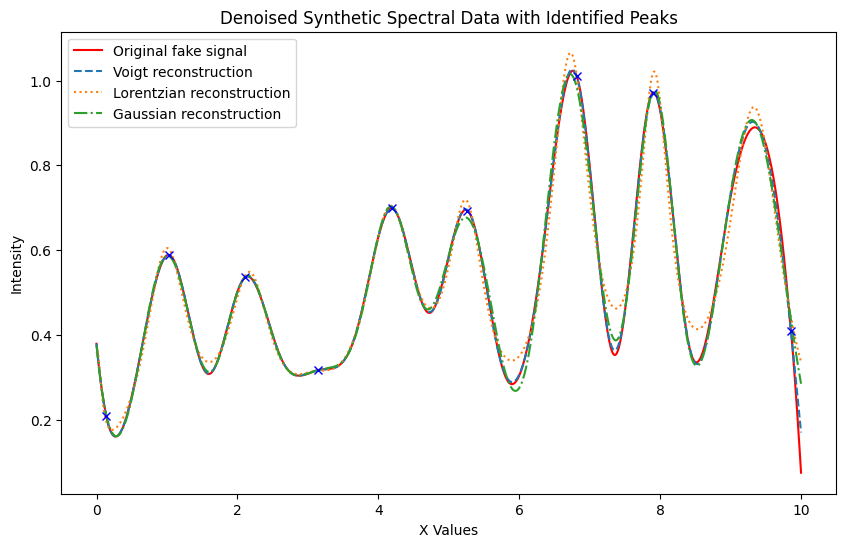

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, 'r', label='Original fake signal')
plt.plot(voigt.x_vals, voigt.results, '--', label='Voigt reconstruction')
plt.plot(lorentz.x_vals, lorentz.results, ':',label='Lorentzian reconstruction')
plt.plot(gauss.x_vals, gauss.results, '-.',label='Gaussian reconstruction')
for p in peaks:
    plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b', marker ='x')
plt.title('Denoised Synthetic Spectral Data with Identified Peaks')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()